**Задача**

В кредитном скоринге важно оценивать изменчивость p(y|x) во времени, т.е. то, как зависимость целевой переменной (дефолта) изменяется в обучающей выборке со временем.
Почему это важно? Потому что в кредитном скоринге используется т.н. "длинный" таргет, из-за которого обучающая выборка сильно отстает во времени от момента применения скоринговой карты и поэтому, анализируя p(y|x) во времени на обучающей выборке, можно увидеть, что какие-то признаки стали менее информативными с т.зр. предсказания y, в других зависимость p(y|x) заметно изменилась, в каких-то сменилась на противоположную.
Такие признаки опасно использовать в модели, несмотря на то, что они информативны.

Оценивать изменчивость p(y|x) можно:
- визуально
- с помощью мат.статистики (стат. тестов и т.п.)

Требуется предложить методы визуального и статистического анализа p(y|x) и реализовать в виде кода.


**Импорт библиотек**

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import resample

In [2]:
warnings.filterwarnings('ignore')

**Загрузка и предобработка данных**

In [3]:
# Загружаем данные
data = pd.read_csv('application_train.csv')

In [80]:
# Избавляемся от nan добавлением средних значений столбцов или unknown

data_description = data.describe()
for col in data:
    if data[col].dtype == 'object':
        data[col].fillna( 'Unknown', inplace=True)
    else:
        data[col].fillna( data_description[col]['mean'], inplace=True)

In [86]:
# Уменьшаем количество объектов нулевого класса до количества объектов класса 1 (downsampling)

examples_negative = data[data['TARGET'] == 0]

examples_negative_downsampled = resample(
            examples_negative,
            replace=True,
            n_samples=len(data[data['TARGET'] == 1]),
            random_state=0
            )
data_resampled = pd.concat((examples_negative_downsampled, data[data['TARGET'] == 1]), axis=0)

print(data_resampled.shape)

(49650, 122)


In [ ]:
'''
# Обработка выбросов
# Для каждой колонки (кроме имеющих тип 'object') отбрасываются значения, которые лежат снаружи интервала
# quantile_25 - 1.5 * (quantile_75 - quantile_25); quantile_75 + 1.5 * (quantile_75 - quantile_25)

# В результате получается пустой датафрейм.
# Возможно, необходимо убрать из цикла колонки, которые имеют равномерное распределение.
# Для отсечки таких колонок можно использовать отношение максимальной частоты в колонке к минимальной.
# Чем это отношение выше, тем менее равномерным является распределение.

quantile_25 = data_resampled.quantile(0.25)
quantile_75 = data_resampled.quantile(0.75)
# Полуторное межквантильное расстояние (квантили 0.75 и 0.25)
alphas = 1.5 * (quantile_75 - quantile_25)

for col in data_resampled.columns:
    if data_resampled[col].dtype != 'object':
        print(col)
        
        data_resampled = data_resampled[
                        (data_resampled[col] >= quantile_25[col] - alphas[col]) &
                        (data_resampled[col] < quantile_75[col] + alphas[col])
                        ]
        print(data_resampled.shape)
'''

In [87]:
# Формируем столбец с целевой переменной
y = data_resampled['TARGET']

# Удаляем столбец с целевой переменной
X = data_resampled.drop(columns=['TARGET'])
X['DAYS_BIRTH'] = X['DAYS_BIRTH'].apply(lambda x: -x/365)
X.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)

In [88]:
col_to_transform = []
# Цикл по столбцам
for col in X:
    # Проверка на соответствие типу 'object'
    if X[col].dtype == 'object':
        # Назначение разных типов трансформеров для данных с разными количествами уникальных значений
        if len(X[col].unique()) <= 3:
            col_to_transform.append( ( [col], LabelEncoder() ) )
        
        else:
            col_to_transform.append( ( [col], OneHotEncoder() ) )
    
    else:
        if len(X[col].unique()) >= 30:
            col_to_transform.append( ( [col], StandardScaler() ) ) 

In [89]:
# Создаем объект DataFrameMapper для трансформации признаков
mapper = DataFrameMapper(col_to_transform, df_out=True)

# Обучаем mapper на данных и трансформируем их
x_processed = mapper.fit_transform(X)

**Обучение модели и предсказание классов для обучающего датасета**

In [90]:
# Проводим кросс-валидацию для модели логистической регрессии,
# находим наилучший коэффициент регуляризации и обучаем лучшую модель
model = GridSearchCV(
    LogisticRegression(random_state=0),
    param_grid={'C': np.arange(0.001, 0.01, 0.001)},
    scoring='roc_auc',
    cv=4,
    verbose=0)

# Обучаем модель на всех имеющихся данных (без тестовой выборки)
model.fit(x_processed, y)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=0),
             param_grid={'C': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])},
             scoring='roc_auc')

In [91]:
# Рассчитываем вероятности каждого класса и сами классы

y_pred = model.predict_proba(x_processed)
y_pred_class = model.predict(x_processed)

**Подготовка данных и построение функции для визуализации и расчета метрики**

In [92]:
# Создаем датафрейм с признаками и значениями целевой переменной (истинные и предсказанные значения)

data_processed = X.copy()
data_processed['TARGET_PROBA'] = y_pred[:,1]
data_processed['TARGET_CLASS'] = y_pred_class
data_processed['TARGET'] = y

# Сортируем датафрейм по столбцу условного времени
data_processed = data_processed.sort_values(by=data_processed.columns[0])

In [93]:
# Функция для расчета автокорреляции списка x со сдвигом lag
def autocorr(x, lag):
    # return np.corrcoef(np.array([x[:round(len(x)/2)], x[round(len(x)/2)+1:len(x)]]))
    return np.correlate(x[:round(len(x)/4)], x[lag:round(len(x)/4) + lag]) 

# Функция для визуализации изменчивости предсказаний модели для указанного признака
def visual(df, time_col, col_to_divide, number_of_feature_ranges, number_of_time_ranges):
    
    # df - данные
    # time_col - имя колонки со временем
    # col_to_divide - имя колонки с признаком
    # gaps_number - количество разбиений по данному признаку
    # time_unit - интервал времени для расчета точности
    
    if df[col_to_divide].dtype == 'object':
        # Сразу же создаем обозначения для легенд на графике
        labels = df[col_to_divide].unique()
        # Расчитываем число разбиений по признаку
        # Если тип признака - 'object', то разбиения по признаку автоматически производятся по уникальным значениям признака
        number_of_feature_ranges = len(df[col_to_divide].unique())
    else:
        # Расчитываем интервал разбиения по признаку
        gap_width = (df[col_to_divide].max() - df[col_to_divide].min()) / number_of_feature_ranges
        
    # Расчитываем величину временного интервала.
    # При правильном подборе параметра number_of_time_ranges временной интервал может быть равен дням, месяцам и т.д.
    time_gap = math.ceil( (df[time_col].max() - df[time_col].min()) / number_of_time_ranges )
    
    score = []

    # Цикл по временным интервалам
    for time_range in range(number_of_time_ranges):
        
        # Извлекаем из датафрейма данные для данного интревала времени
        df_time_divided = df[
                             (df[time_col] >= df[time_col].min() + time_gap * time_range) &
                             (df[time_col] < df[time_col].min() + time_gap * (time_range + 1))
                            ]
        
        if df[col_to_divide].dtype == 'object':
            # Формируем список датафреймов, содержащих поддиапазоны указанного признака в данный интервал времени
            gaps_data = [ df_time_divided[df_time_divided[col_to_divide] == item] for item in df[col_to_divide].unique() ]
         
        else:
            # Цикл по интервалам значений признака.
            # На каждой итерации из датафрейма, разделенного по времени извлекается определенный поддиапазон данных
            # и добавляется в список gaps_data.
            gaps_data, labels = [], []
            for gap in range(number_of_feature_ranges+1):
                
                # Рассчитываем левую и правую границы интервала разбиения признака
                gap_edge_left = df_time_divided[col_to_divide].min() + gap * gap_width
                gap_edge_right = df_time_divided[col_to_divide].min() + (gap + 1) * gap_width
                
                # Формируем список для будущих обозначений на легенде графика
                labels.append( f'{col_to_divide}: {round(gap_edge_left, 2)}-{round(gap_edge_right, 2)}' )
                
                # Добавляем в список элементы разбиения по признаку
                gaps_data.append(df_time_divided[
                    (df_time_divided[col_to_divide] >= gap_edge_left) &
                    (df_time_divided[col_to_divide] < gap_edge_right)
                    ]
                                )
        
        score.append([])
        
        # Цикл по интервалам значений признака 
        for gap in range(len(gaps_data)):
            
            # Извлекаем истинные и предсказанные значения для заданных диапазонов признака и времени
            y_loc = gaps_data[gap]['TARGET']
            y_pred_loc = gaps_data[gap]['TARGET_CLASS']
            
            # Рассчитываем точность предсказания в заданном диапазоне и добавляем в список
            score[time_range].append(accuracy_score(y_loc, y_pred_loc))
          
    score = np.array(score)
    
    # Цикл по интервалам разбиения признака
    for gap in range(len(score.T)):
        
        # Выводим значение автокорреляции для данного поддиапазона (значения) признака
        print(f'Автокорреляция для интервала {gap+1}: {autocorr(score[gap], round(len(score[gap])/2))}')
        
        # Строим график зависимости точности предсказания от временного интервала
        plt.plot(
            np.linspace(1, number_of_time_ranges, len(score[gap])),
            score[gap],
            label=labels[gap]
            )
        plt.xlabel('TIME')
        plt.ylabel('ACCURACY')
        # plt.ylim([0.0, 1.05])
        plt.legend(loc=(1, 0))

**Визуализация некоторых признаков**

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]


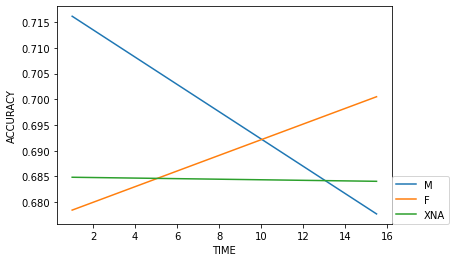

In [94]:
c = visual(data_processed, 'SK_ID_CURR', 'CODE_GENDER', 4, 30)

Автокорреляция для интервала 1: [0.46911891]
Автокорреляция для интервала 2: [0.45645318]
Автокорреляция для интервала 3: [0.46784286]
Автокорреляция для интервала 4: [0.4756439]
Автокорреляция для интервала 5: [0.4506928]


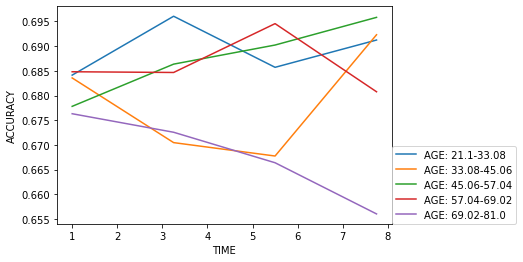

In [95]:
c = visual(data_processed, 'SK_ID_CURR', 'AGE', 4, 10)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]
Автокорреляция для интервала 6: [nan]


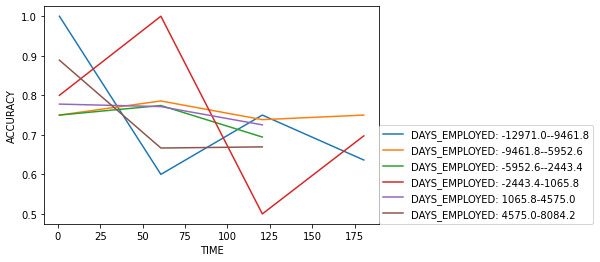

In [96]:
# Отбрасываем строки, в которых количество отработанных дней меньше 15000, чтобы избавиться от выбросов
c = visual(data_processed[data_processed['DAYS_EMPLOYED'] < 15000], 'SK_ID_CURR', 'DAYS_EMPLOYED', 5, 300)

Автокорреляция для интервала 1: [1.12084877]
Автокорреляция для интервала 2: [0.99179602]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [1.01172918]
Автокорреляция для интервала 6: [0.99568346]


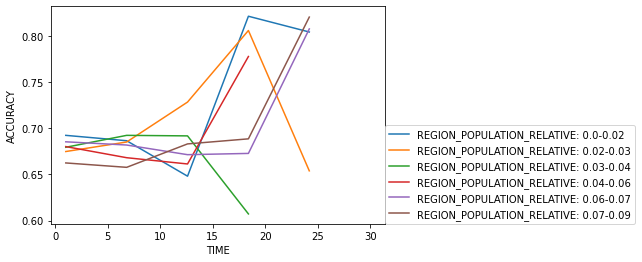

In [99]:
# Отбрасываем строки, в которых количество отработанных дней больше 20000, чтобы избавиться от выбросов
c = visual(data_processed, 'SK_ID_CURR', 'REGION_POPULATION_RELATIVE', 5, 30)

Автокорреляция для интервала 1: [nan]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [nan]
Автокорреляция для интервала 4: [nan]
Автокорреляция для интервала 5: [nan]
Автокорреляция для интервала 6: [nan]


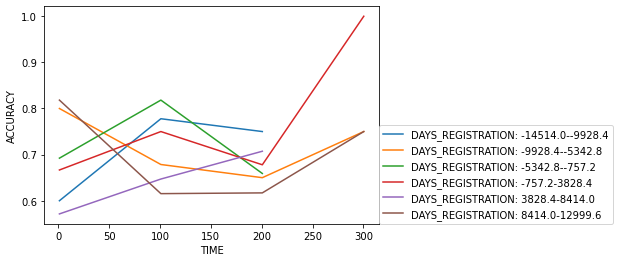

In [103]:
c = visual(data_processed, 'SK_ID_CURR', 'DAYS_REGISTRATION', 5, 500)

Автокорреляция для интервала 1: [0.24786325]
Автокорреляция для интервала 2: [0.68292683]
Автокорреляция для интервала 3: [1.38505449]
Автокорреляция для интервала 4: [0.53333333]
Автокорреляция для интервала 5: [nan]
Автокорреляция для интервала 6: [nan]


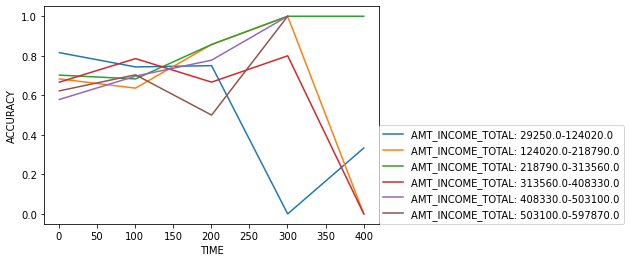

In [104]:
# Отбрасываем строки, в которых зарплата больше 500000, чтобы избавиться от выбросов
c = visual(data_processed[data_processed['AMT_INCOME_TOTAL'] < 500000], 'SK_ID_CURR', 'AMT_INCOME_TOTAL', 5, 500)

Автокорреляция для интервала 1: [1.59480519]
Автокорреляция для интервала 2: [nan]
Автокорреляция для интервала 3: [1.0875]
Автокорреляция для интервала 4: [1.13919414]
Автокорреляция для интервала 5: [nan]
Автокорреляция для интервала 6: [0.83333333]


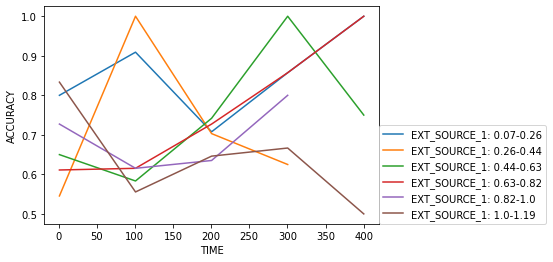

In [105]:
c = visual(data_processed, 'SK_ID_CURR', 'EXT_SOURCE_1', 5, 500)

Автокорреляция для интервала 1: [1.37073348]
Автокорреляция для интервала 2: [1.02277778]
Автокорреляция для интервала 3: [1.05785774]
Автокорреляция для интервала 4: [1.02567273]
Автокорреляция для интервала 5: [0.90144231]
Автокорреляция для интервала 6: [1.03764642]


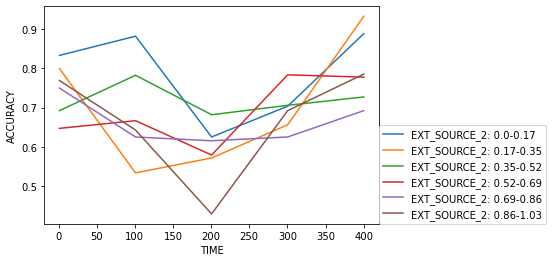

In [106]:
c = visual(data_processed, 'SK_ID_CURR', 'EXT_SOURCE_2', 5, 500)

Автокорреляция для интервала 1: [1.19166667]
Автокорреляция для интервала 2: [0.9592437]
Автокорреляция для интервала 3: [1.3387218]
Автокорреляция для интервала 4: [1.38277311]
Автокорреляция для интервала 5: [1.18530021]
Автокорреляция для интервала 6: [0.71853147]


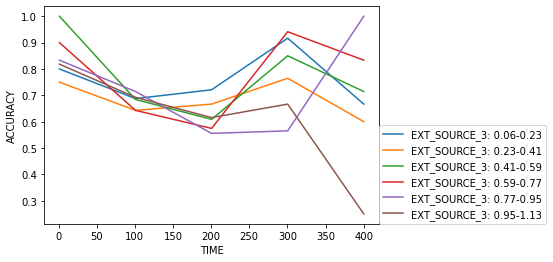

In [107]:
c = visual(data_processed, 'SK_ID_CURR', 'EXT_SOURCE_3', 5, 500)

**Вывод**

На графике (при вызове функции visual) представлена зависимость точности предсказания от номера временного диапазона. Все временные диапазоны имеют одинаковую длину, поэтому, правильно задавая параметр number_of_time_ranges, можно добиться того, что временные диапазоны будут соответствовать дням, месяцам, годам и т.д. По этому графику можно оценить временное изменение качества модели для различных диапазонов выбранного признака. Значение accuracy связано с вероятностью принадлежности объекта к какому-либо классу. Если значение accuracy сильно изменяется с течением времени (наблюдаются скачки на графике), то это может означать, что в более поздние моменты времени появился какой-то фактор, который не учтен в модели. При этом точность модели может резко возрастать, но это не гарантирует, что в скором времени качество предсказания не ухудшится.

В качестве метрики для оценки изменчивости зависимости точности предсказания от времени может быть использована автокорреляция. Низкое значение автокорреляции будет свидетельствовать об изменении зависимости точности предсказания от времени.

Нерешённые проблемы:
1. Если в элементе разбиения данных по времени отсутствуют объекты, соответствующие определенному диапазону признаков, то score в этом случае принимает значение nan. Это приводит к отсутствию данных на графике для данного времени и диапазона, а также к тому, что автокорреляция принимает значение nan
2. Наличие выбросов (необходима более тщательная предобработка данных).